In [23]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras import models,layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV3Large


In [24]:
#load the dataset from a csv file
data=pd.read_csv('smdg/metadata - standardized.csv',index_col=None)

In [25]:
#Now we define a function to append .png extension to file names

def append_ext(fn):
    return fn+".png"



```fundus_subset = data[(data['fundus'].notnull()) & (data['fundus'] != -1)]```

This code creates a new DataFrame called fundus_subset by selecting rows from the original DataFrame data where the 'fundus' column is not null (i.e., it contains a valid value) and not equal to -1. This filter operation removes --rows where 'fundus' is either null or -1.

-------------------------------------


```fundus_subset = fundus_subset[['types', 'fundus', 'names']]```

In this line, the code further refines the fundus_subset DataFrame by selecting only the columns 'types', 'fundus', and 'names' for further processing. This reduces the DataFrame to contain only these three columns.

------------------------------------------

```fundus_subset['combined'] = fundus_subset['names'].apply(append_ext)```

Here, a new column 'combined' is created in the fundus_subset DataFrame. This column is generated by applying the append_ext function to each value in the 'names' column. The apply function is used to apply a custom function (append_ext) to each element in the 'names' column and store the results in the 'combined' column.

-------------------------------------------

```fundus_subset['fundus'] = fundus_subset['fundus'].astype(str) and fundus_subset['types'] = fundus_subset['types'].astype(str)```

These lines of code convert the 'fundus' and 'types' columns to string data types explicitly. This conversion ensures that these columns contain string values, which can be useful for further processing or analysis

In [26]:
fundus_subset=data[(data['fundus'].notnull()) & (data['fundus']!=-1)]

fundus_subset=fundus_subset[['types','fundus','names']]

fundus_subset['combined']=fundus_subset['names'].apply(append_ext)
## .apply() in pandas allows us to apply a function along an axis of a Dataframe

In [27]:
fundus_subset['fundus']=fundus_subset['fundus'].astype(str)

fundus_subset['types']=fundus_subset['types'].astype(str)

In [28]:
##Glaucoma fundus images
glaucomaCount=len(fundus_subset[(fundus_subset['types']=='1')])
print(glaucomaCount)

4767


In [29]:
#healthy fundus images
healthyCount=len(fundus_subset[(fundus_subset['types']=='0')])
print(healthyCount)

7549


In [30]:
#Randomize the data to create balanced training, validation and testing sets
fundus_subset_random=fundus_subset.sample(frac=1,random_state=1)



In [31]:
healthy_subset=fundus_subset_random[fundus_subset_random['types']=='0']

In [32]:
glaucoma_subset=fundus_subset_random[fundus_subset_random['types']=='1']

In [33]:
testSize=1000
valSize=1000

#Get train items
healthy_train=healthy_subset.head(healthyCount-testSize-valSize)
glaucoma_train=glaucoma_subset.head(glaucomaCount-valSize)
train = pd.concat([healthy_train, glaucoma_train], ignore_index=True)

#get val items
healthy_val = healthy_subset.tail(valSize)
glaucoma_val = glaucoma_subset.tail(valSize)
val = pd.concat([healthy_val, glaucoma_val], ignore_index=True)

In [34]:
# get test items
healthy_test = healthy_subset.tail(testSize)
glaucoma_test = glaucoma_subset.tail(testSize)
test = pd.concat([healthy_test, glaucoma_test], ignore_index=True)

In [35]:
print("Train Size: ", len(train))
print("Val Size: ", len(val))
print("Test Size: ", len(test))

Train Size:  9316
Val Size:  2000
Test Size:  2000


In [36]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 

In [38]:
#Setting target size and batch size for data generator
target=224
batchSize=8

#Set the class mode to 'binary' for training data generator
classes='binary'

#Create the training data generator
trainDataGen=ImageDataGenerator(preprocessing_function=preprocess_input)
trainGen=trainDataGen.flow_from_dataframe(dataframe=train,directory='smdg/full-fundus/full-fundus',
                                         class_mode=classes,batch_size=batchSize,shuffle=True,x_col='combined',y_col='types',validate_filenames=True,target_size=(target,target),color_mode='rgb')

Found 9316 validated image filenames belonging to 2 classes.


In [39]:
#Create the validation data generator
valDataGen=ImageDataGenerator(preprocessing_function=preprocess_input)
valGen=valDataGen.flow_from_dataframe(dataframe=val,directory='smdg/full-fundus/full-fundus',batch_size=batchSize,class_mode=classes,shuffle=False,x_col='combined',y_col='types',validate_filenames=True,target_size=(target,target),color_mode='rgb')

Found 2000 validated image filenames belonging to 2 classes.


In [40]:
# Create the testing data generator
testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
testGen = testDataGen.flow_from_dataframe(dataframe=test,
                                           directory='smdg/full-fundus/full-fundus',   
                                           batch_size = batchSize, 
                                           class_mode = classes,
                                           shuffle=False, 
                                           x_col="combined", 
                                           y_col="types", 
                                           validate_filenames=True, 
                                           target_size=(target, target), 
                                           color_mode='rgb')

Found 2000 validated image filenames belonging to 2 classes.


### Generate Data Batches for Healthy_Subset and Glaucoma_Subset so that it can be visualized

In [42]:
#Set class mode to 'sparse' for visualization of data generators
classes='sparse'

# Create data generators for healthy and glaucoma subsets for visualization
healthy_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
healthy_subset_Gen = trainDataGen.flow_from_dataframe(dataframe=healthy_subset, 
                                            directory='smdg/full-fundus/full-fundus', 
                                            class_mode = classes,
                                            batch_size = batchSize, 
                                            shuffle=True, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


glaucoma_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
glaucoma_subset_Gen = glaucoma_subsetDataGen.flow_from_dataframe(dataframe=glaucoma_subset, 
                                            directory='smdg/full-fundus/full-fundus', 
                                            class_mode = classes,
                                            batch_size = batchSize, 
                                            shuffle=True, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 7549 validated image filenames belonging to 1 classes.
Found 4767 validated image filenames belonging to 1 classes.


In [43]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

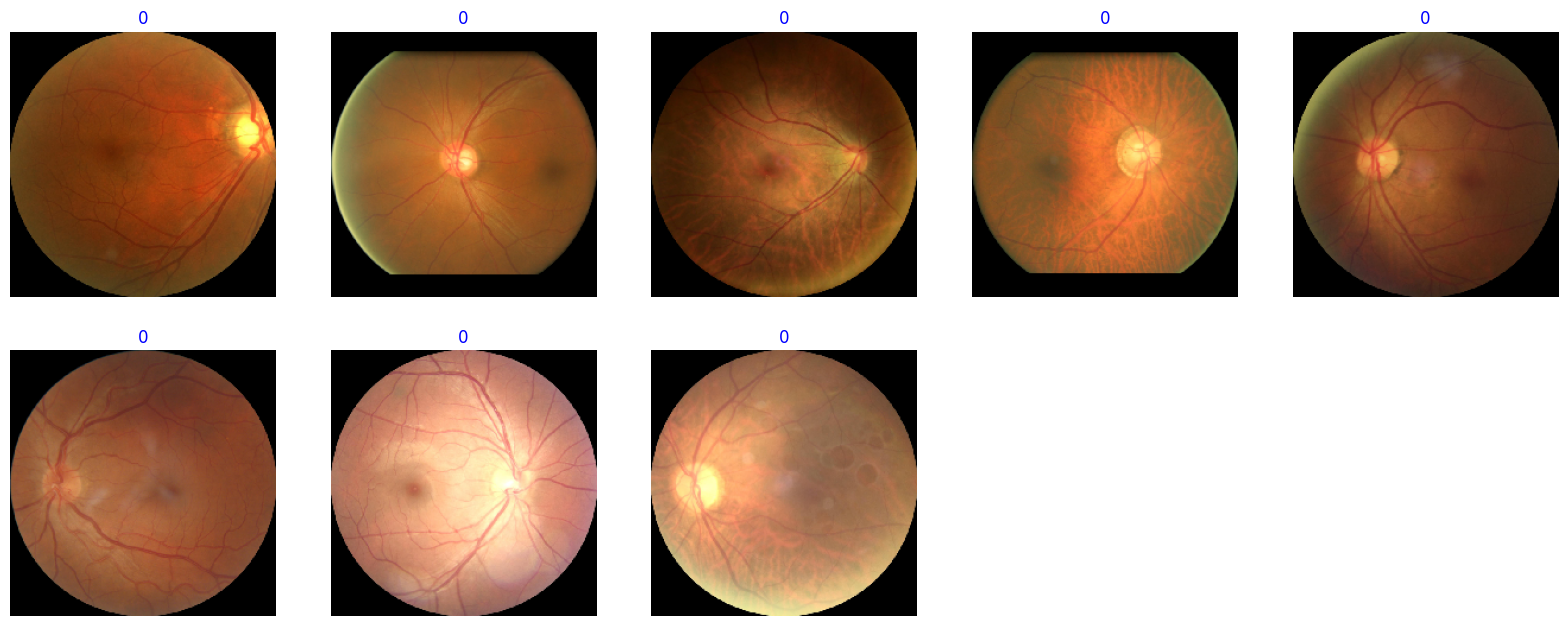

In [44]:
show_images(healthy_subset_Gen)

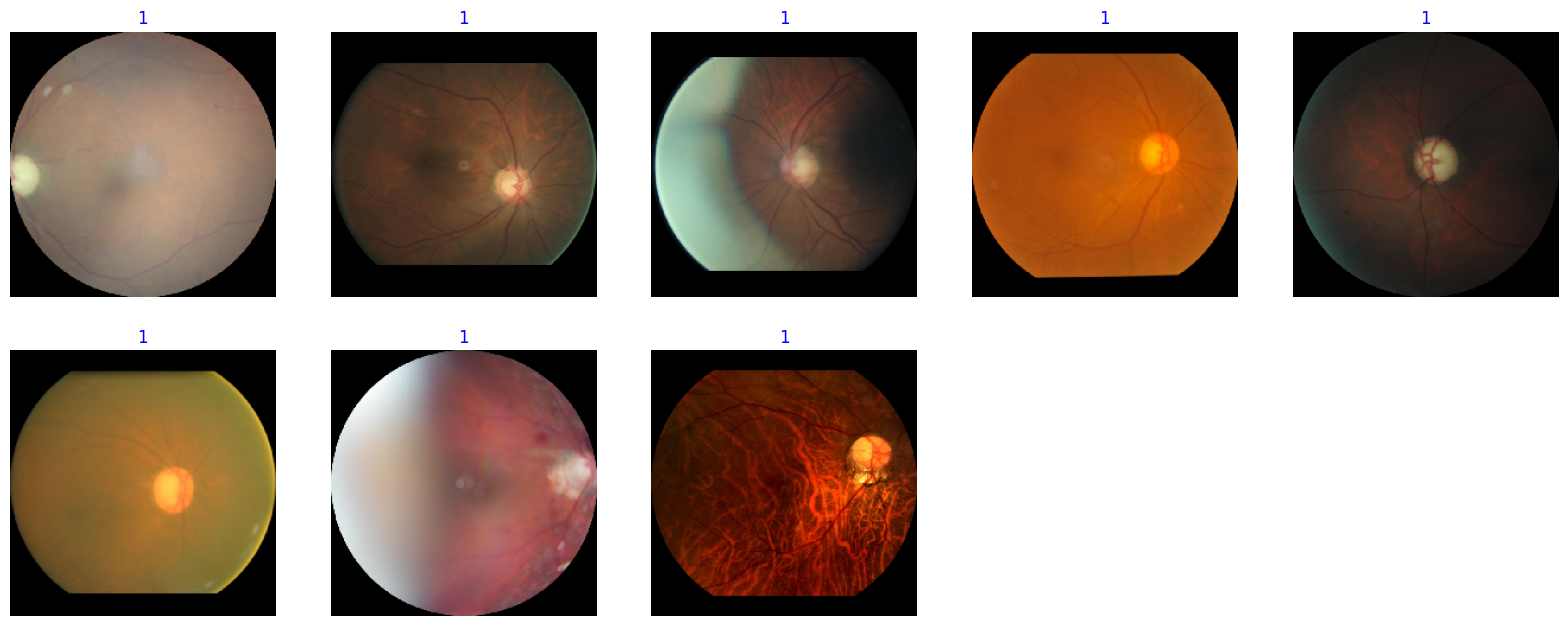

In [45]:
show_images(glaucoma_subset_Gen)

### Create Baseline Model using MobileNetV3-Large and Compile the mode

In [57]:
baseline_model=tf.keras.applications.MobileNetV3Large(weights='imagenet',input_shape=(224,224,3),include_preprocessing=False,include_top=False)
for layer in baseline_model.layers:
    layer.trainable=False
    

In [58]:
print(baseline_model.summary())

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 112, 112, 16  64         ['Conv[0][0]']                   
 tion)                          )                                                  

 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_203 (ReLU)               (None, 56, 56, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 56, 56, 24)  1728        ['re_lu_203[0][0]']              
 D)                                                                                               
                                                                                                  
 expanded_conv_2/project/BatchN  (None, 56, 56, 24)  96          ['expanded_conv_2/project[0][0]']
 orm (BatchNormalization)                                                                         
          

 re_lu_208 (ReLU)               (None, 28, 28, 120)  0           ['expanded_conv_4/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_208[0][0]']              
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
                                                                                                  
 expanded_

 D)                                                              Mul[0][0]']                      
                                                                                                  
 expanded_conv_5/project/BatchN  (None, 28, 28, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 28, 28, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 28, 28, 240)  9600       ['expanded_conv_5/Add[0][0]']    
 )        

                                                                                                  
 re_lu_216 (ReLU)               (None, 14, 14, 200)  0           ['tf.__operators__.add_150[0][0]'
                                                                 ]                                
                                                                                                  
 tf.math.multiply_150 (TFOpLamb  (None, 14, 14, 200)  0          ['re_lu_216[0][0]']              
 da)                                                                                              
                                                                                                  
 multiply_107 (Multiply)        (None, 14, 14, 200)  0           ['expanded_conv_7/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_150[0][0]']   
          

 da)                                                                                              
                                                                                                  
 multiply_110 (Multiply)        (None, 14, 14, 184)  0           ['expanded_conv_9/expand/BatchNor
                                                                 m[0][0]',                        
                                                                  'tf.math.multiply_153[0][0]']   
                                                                                                  
 expanded_conv_9/depthwise (Dep  (None, 14, 14, 184)  1656       ['multiply_110[0][0]']           
 thwiseConv2D)                                                                                    
                                                                                                  
 expanded_conv_9/depthwise/Batc  (None, 14, 14, 184)  736        ['expanded_conv_9/depthwise[0][0]
 hNorm (Ba

 expanded_conv_10/squeeze_excit  (None, 1, 1, 480)   58080       ['expanded_conv_10/squeeze_excite
 e/Conv_1 (Conv2D)                                               /Relu[0][0]']                    
                                                                                                  
 tf.__operators__.add_157 (TFOp  (None, 1, 1, 480)   0           ['expanded_conv_10/squeeze_excite
 Lambda)                                                         /Conv_1[0][0]']                  
                                                                                                  
 re_lu_223 (ReLU)               (None, 1, 1, 480)    0           ['tf.__operators__.add_157[0][0]'
                                                                 ]                                
                                                                                                  
 tf.math.multiply_157 (TFOpLamb  (None, 1, 1, 480)   0           ['re_lu_223[0][0]']              
 da)      

                                                                                                  
 expanded_conv_11/project (Conv  (None, 14, 14, 112)  75264      ['expanded_conv_11/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_11/project/Batch  (None, 14, 14, 112)  448        ['expanded_conv_11/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
                                                                                                  
 expanded_conv_11/Add (Add)     (None, 14, 14, 112)  0           ['expanded_conv_10/project/BatchN
                                                                 orm[0][0]',                      
                                                                  'expanded_conv_11/project/BatchN
          

                                                                                                  
 expanded_conv_13/expand (Conv2  (None, 7, 7, 960)   153600      ['expanded_conv_12/project/BatchN
 D)                                                              orm[0][0]']                      
                                                                                                  
 expanded_conv_13/expand/BatchN  (None, 7, 7, 960)   3840        ['expanded_conv_13/expand[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 tf.__operators__.add_164 (TFOp  (None, 7, 7, 960)   0           ['expanded_conv_13/expand/BatchNo
 Lambda)                                                         rm[0][0]']                       
                                                                                                  
 re_lu_230

                                                                                                  
 re_lu_233 (ReLU)               (None, 7, 7, 960)    0           ['tf.__operators__.add_167[0][0]'
                                                                 ]                                
                                                                                                  
 tf.math.multiply_167 (TFOpLamb  (None, 7, 7, 960)   0           ['re_lu_233[0][0]']              
 da)                                                                                              
                                                                                                  
 multiply_120 (Multiply)        (None, 7, 7, 960)    0           ['expanded_conv_14/expand/BatchNo
                                                                 rm[0][0]',                       
                                                                  'tf.math.multiply_167[0][0]']   
          

Total params: 2,996,352
Trainable params: 0
Non-trainable params: 2,996,352
__________________________________________________________________________________________________
None


In [59]:
# Build the custom model on top of the MobileNetV2 base
model = Sequential()
model.add(baseline_model) 
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(GlobalMaxPooling2D()) 
model.add(BatchNormalization())
model.add(Dense(512, activation = 'relu')) 
model.add(BatchNormalization()) 
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 dense (Dense)               (None, 7, 7, 512)         492032    
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 7, 7, 512)         262656    
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                        

In [60]:
def f1_score_metric(y_true,y_pred):
    y_pred=tf.round(y_pred)
    return 2*tf.reduce_sum(y_true*y_pred)/(tf.reduce_sum(y_true)+tf.reduce_sum(y_pred)+tf.keras.backend.epsilon())

In [61]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy','Precision','Recall','AUC',f1_score_metric]
)

In [62]:
# Train the model
history=model.fit(
    trainGen,
    epochs=10,
    batch_size=64,
    validation_data=valGen
)

Epoch 1/10
1165/1165 [==============================] - 94s 62ms/step - loss: 0.7507 - accuracy: 0.5640 - precision: 0.4466 - recall: 0.3276 - auc: 0.5350 - f1_score_metric: 0.3465 - val_loss: 0.7350 - val_accuracy: 0.5560 - val_precision: 0.6273 - val_recall: 0.2760 - val_auc: 0.5757 - val_f1_score_metric: 0.2051
Epoch 2/10
1165/1165 [==============================] - 68s 58ms/step - loss: 0.6850 - accuracy: 0.5865 - precision: 0.4813 - recall: 0.2902 - auc: 0.5688 - f1_score_metric: 0.3296 - val_loss: 0.7743 - val_accuracy: 0.5370 - val_precision: 0.6267 - val_recall: 0.1830 - val_auc: 0.5417 - val_f1_score_metric: 0.1442
Epoch 3/10
1165/1165 [==============================] - 68s 59ms/step - loss: 0.6810 - accuracy: 0.5965 - precision: 0.5018 - recall: 0.3016 - auc: 0.5733 - f1_score_metric: 0.3460 - val_loss: 0.7333 - val_accuracy: 0.5360 - val_precision: 0.7069 - val_recall: 0.1230 - val_auc: 0.5747 - val_f1_score_metric: 0.1014
Epoch 4/10
1165/1165 [==============================

In [63]:
# Evaluate the model on the validation data
score=model.evaluate(valGen)
score

250/250 [==============================] - 11s 44ms/step - loss: 0.7303 - accuracy: 0.5755 - precision: 0.6768 - recall: 0.2890 - auc: 0.6335 - f1_score_metric: 0.2120


[0.7302681803703308,
 0.5755000114440918,
 0.6768149733543396,
 0.289000004529953,
 0.6335490345954895,
 0.21199160814285278]

In [64]:
# Plot the training and validation accuracy and loss
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

ModuleNotFoundError: No module named 'seaborn'